<a href="https://colab.research.google.com/github/lbk209/topic_modeling/blob/main/tm_develop_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
%%capture
!pip install bertopic

In [136]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np
import tqdm
import datetime

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', 5000)

import plotly.io as pio
pio.templates.default = 'simple_white'
from bertopic import BERTopic

# Data

In [137]:
path_src = '/content/drive/MyDrive/Colab\ Notebooks'
path_data = 'sample_data'

In [138]:
file = 'hotel_reviews_with_transl'
!unzip -n {path_src}/{file}.zip -d {path_data}

Archive:  /content/drive/MyDrive/Colab Notebooks/hotel_reviews_with_transl.zip


In [139]:
f = f'{path_data}/{file}.csv'
df_data = pd.read_csv(f, sep = '\t')

In [140]:
df_data.head()

,id,hotel,review,lang,reviews_transl,reviews_len
0,0,Travelodge,"A good budget choice but only if you can't afford better!. GOOD POINTS-Cheap (I stayed here for some nights for 20 pounds - this is fantastic for central London)- Family rooms are spacious for 2 people- Restaurants very close eg Nanos (portugese), Strada (Italian), Pasta, fast food at the station etc)- Staff are friendly-Early check in available (but at a cost). Some hotels I have been in do not even allow early check in so I put this as a good point.-Safe area.BAD POINTS-Mattress was uncomfortable - sinks in the middle. My wife had back problems every day (!)-Pillows are thin, hard and uncomfortable. I ended up buying a couple as I was staying for 2 weeks. - Road noise when windows are open is load but okay when windows are closed-Air -conditioning does not work in any room I have been in (I have tried 5 rooms). Windows open with a key that is available at reception though.-Towels aren't very good and often you have to ask for more.-Double rooms felt claustrophobic!",en,"A good budget choice but only if you can't afford better!. GOOD POINTS-Cheap (I stayed here for some nights for 20 pounds - this is fantastic for central London)- Family rooms are spacious for 2 people- Restaurants very close eg Nanos (portugese), Strada (Italian), Pasta, fast food at the station etc)- Staff are friendly-Early check in available (but at a cost). Some hotels I have been in do not even allow early check in so I put this as a good point.-Safe area.BAD POINTS-Mattress was uncomfortable - sinks in the middle. My wife had back problems every day (!)-Pillows are thin, hard and uncomfortable. I ended up buying a couple as I was staying for 2 weeks. - Road noise when windows are open is load but okay when windows are closed-Air -conditioning does not work in any room I have been in (I have tried 5 rooms). Windows open with a key that is available at reception though.-Towels aren't very good and often you have to ask for more.-Double rooms felt claustrophobic!",981
1,1,Travelodge,"Wont be recommending this Travelodge.. We booked this travelodge for the convenience to Euston Station, we had to catch an early train to Scotland. Had I known that it would be so uncomfortable I would have saved myself the money and slept on a seat at the train station. You could feel the springs through the mattress as you slept and the pillows were so thin that you may aswell not have had one at all. We had previously stayed at Travelodge Kings Cross and were under the impression that Euston would be of the same standard. This is not the case and I will not be recommending this hotel to anyone.",en,"Wont be recommending this Travelodge.. We booked this travelodge for the convenience to Euston Station, we had to catch an early train to Scotland. Had I known that it would be so uncomfortable I would have saved myself the money and slept on a seat at the train station. You could feel the springs through the mattress as you slept and the pillows were so thin that you may aswell not have had one at all. We had previously stayed at Travelodge Kings Cross and were under the impression that Euston would be of the same standard. This is not the case and I will not be recommending this hotel to anyone.",604
2,2,Travelodge,travelodge stay. was a great stay. loved it. the whole weekend was great. will defonatly go there again.,en,travelodge stay. was a great stay. loved it. the whole weekend was great. will defonatly go there again.,104
3,3,Travelodge,"It's a shame about the Noise!. The hotel was good and did the job for 1 night, I wouldn't want a 2nd night. The hotel I'm afraid was let down by the noise in the rooms from the roads outside. This is very disturbing and I do believe work is required to ensure that the rooms are a little more sound proofing. All night long traffic noise can be heard and this meant for a very disturbed nights sleep for all our family. The hotel needs to work on this as it has been noted by a

In [147]:
# testing
df_data = df_data.sample(frac=.5)

In [ ]:
df_data = df_data.drop('id', axis=1).reset_index(drop=True)

In [149]:
df_data.review.count()

6148

In [150]:
docs = df_data.reviews_transl.tolist()

# 🗨️ **BERTopic**

In [151]:
def get_topic_stats(topic_model, extra_cols = []):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    return topics_info_df[['Topic', 'Count', 'Share', 'CumulativeShare', 'Name', 'Representation'] + extra_cols]

In [152]:
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, PartOfSpeech, MaximalMarginalRelevance

main_representation_model = KeyBERTInspired()
aspect_representation_model1 = PartOfSpeech("en_core_web_sm")
aspect_representation_model2 = [KeyBERTInspired(top_n_words=30), MaximalMarginalRelevance(diversity=.5)]

representation_model = {
   "Main": main_representation_model,
   "Aspect1":  aspect_representation_model1,
   "Aspect2":  aspect_representation_model2
}

vectorizer_model = CountVectorizer(min_df=5, stop_words = 'english')
topic_model = BERTopic(nr_topics = 'auto', vectorizer_model = vectorizer_model,
                      representation_model = representation_model)
topics, ini_probs = topic_model.fit_transform(docs)

In [158]:
num_topics = len(topic_model.get_topics()) - 1
num_topics

48

In [159]:
get_topic_stats(topic_model, ['Aspect1', 'Aspect2']).head(7).set_index('Topic')

,Count,Share,CumulativeShare,Name,Representation,Aspect1,Aspect2
Topic,,,,,,,
-1,3077,50.05,50.05,-1_hotel_hotels_rooms_room,"[hotel, hotels, rooms, room, london, bathroom, inn, place, shower, bed]","[room, hotel, good, breakfast, location, stay, staff, great, clean, rooms]","[hotels, room, london, shower, booked, restaurant, bus, station, nights, recommend]"
0,1043,16.96,67.01,0_hotel_hotels_rooms_paddington,"[hotel, hotels, rooms, paddington, london, heathrow, covent, room, station, bathroom]","[hotel, station, great, location, good, stay, room, breakfast, walk, clean]","[hotels, paddington, heathrow, covent, bathroom, victoria, express, waterloo, central, comfortable]"
1,547,8.90,75.91,1_hotel_hotels_rooms_booking,"[hotel, hotels, rooms, booking, room, booked, reception, bed, restaurant, place]","[hotel, room, staff, rooms, good, service, stay, noise, location, night]","[hotel, rooms, booking, reception, experience, lobby, stayed, area, service, double]"
2,107,1.74,77.65,2_hotel_hotels_hilton_hiltons,"[hotel, hotels, hilton, hiltons, london, thames, rooms, lounge, restaurant, room]","[hilton, bridge, tower, hotel, executive, room, hiltons, good, staff, lounge]","[hotels, hilton, thames, lounge, room, kensington, reviews, station, stayed, weekend]"
3,105,1.71,79.36,3_radisson_radissons_hotel_hotels,"[radisson, radissons, hotel, hotels, edwardian, raddison, rooms, vanderbilt, room, oxford]","[hotel, location, staff, room, stay, great, hotels, excellent, good, street]","[radissons, hotels, vanderbilt, room, oxford, museum, leicester, shower, garden, staff]"
4,90,1.46,80.82,4_gloucester_hotels_hotel_london,"[gloucester, hotels, hotel, london, rooms, restaurants, place, pub, places, room]","[gloucester, tube, road, room, millennium, hotel, location, millenium, club, station]","[gloucester, hotels, rooms, place, pub, heathrow, kensington, museum, cromwell, recommend]"
5,75,1.22,82.04,5_mayfair_london_hotel_hotels,"[mayfair, london, hotel, hotels, piccadilly, buckingham, amenities, palace, inn, restaurants]","[mayfair, green, inn, location, park, hotel, excellent, room, street, great]","[mayfair, hotels, piccadilly, buckingham, amenities, palace, bar, bathroom, sainsburys, corner]"


In [155]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)

In [160]:
topic_model.visualize_topics()

In [168]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, window = 4,
                                                                      calculate_tokens=True)

In [169]:
topic_distr.shape

(6148, 48)

In [170]:
topic_distr

array([[0.06371714, 0.06873226, 0.0132352 , ..., 0.00121798, 0.005349  ,
        0.03482469],
       [0.05241437, 0.04816061, 0.0202135 , ..., 0.06517852, 0.01004273,
        0.01279541],
       [0.05224263, 0.0837024 , 0.01374098, ..., 0.        , 0.00382569,
        0.04156356],
       ...,
       [0.05090641, 0.04772442, 0.01767312, ..., 0.        , 0.        ,
        0.06165296],
       [0.04443437, 0.05440567, 0.02188142, ..., 0.00669112, 0.00992321,
        0.01245146],
       [0.05238923, 0.05312501, 0.09075179, ..., 0.00346122, 0.00794154,
        0.00982997]])

Text(0.5, 1.0, 'Distribution of topic non-zero probabilities')

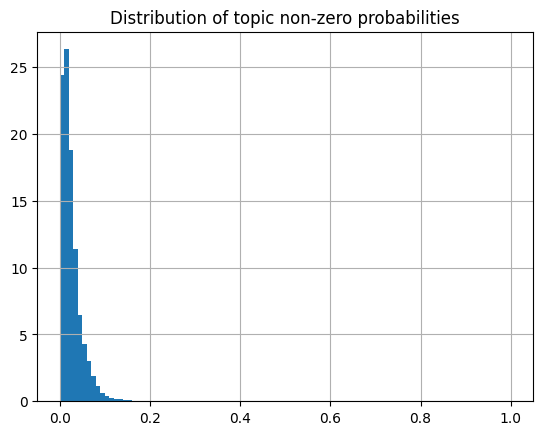

In [171]:
raw_distr = pd.Series(topic_distr.ravel())
raw_distr = raw_distr[raw_distr > 0]

ax = raw_distr.hist(bins = 100, range = [0, 1],
                                        weights = np.ones_like(raw_distr)*100/raw_distr.shape[0])
ax.set_title('Distribution of topic non-zero probabilities')

In [172]:
df_data['max_topic_distr'] = topic_distr.max(axis = 1)

In [173]:
 df_data[df_data.max_topic_distr > 0.05].shape

(6104, 7)

In [174]:
1 - df_data[df_data.max_topic_distr > 0.05].shape[0]/df_data.shape[0]

0.0071567989590111125

In [175]:
df_data.head(3)

,hotel,review,lang,reviews_transl,reviews_len,basic_topic,max_topic_distr
0,Hilton,"very convinient location. My room on the 3rd floor was spacious, clean. Lighting was good, both in room and bathroom. Room was a little worn, as some of the wallpaper had marks or was peeling off. The matrasse was not the newest either, fairly cheap quality. In the bathroom the tub was a little mildewy though and smelled -even the next day- of chlorid cleaner. (So is was probably clean, I did not have somebody making up my room due to the Do not Disturb Sign at the door.) The shower curtain was missing the interior part. Spacious bathroom with plenty of space to place bathroom amenities. The room windows open a little, so you do not have to rely on AC, which was working very well (it was set for cooling, which I did not need). The roomwalls were not too thick, I was lucky that my neighbor did not turn on the TV too loudly. Internet access is very expensive with PoundSterling 15,- per 24h. Check-in staff allowed me into the room earlier. Thank you! Breakfast was of intermediate quality, basically nothing special taste-wise, though the staff working there was very friendly, helpful and service-oriented. The same I can say about the check-in and concierge staff. The selling point was for me the easy access from the airport. Heathrow Express brings you from the LHR airport to the hotel located in the Paddington Station within 20minutes. Underneath/next to the hotel is theTube Station of three different subway lines, one of them the Bakerloo Line, that easily brings you within 15 minutes to the West End...The PA system is definately working. I was lucky to experience it, due to the in London not so unusual evacuation alarm going off at one evening. The hotel appears pretty secure due to plenty of CCTV cameras located at all corners of all ceilings, though elevator access is not restricted by room key cards and the street emergency exits did not close either behind me during the evacuation. However, I would stay again, rather have one fake alarm too many than a real fire. During the evacuation I noticed that my room did not have a safety exit map posted on the room's door.",en,"very convinient location. My room on the 3rd floor was spacious, clean. Lighting was good, both in room and bathroom. Room was a little worn, as some of the wallpaper had marks or was peeling off. The matrasse was not the newest either, fairly cheap quality. In the bathroom the tub was a little mildewy though and smelled -even the next day- of chlorid cleaner. (So is was probably clean, I did not have somebody making up my room due to the Do not Disturb Sign at the door.) The shower curtain was missing the interior part. Spacious bathroom with plenty of space to place bathroom amenities. The room windows open a little, so you do not have to rely on AC, which was working very well (it was set for cooling, which I did not need). The roomwalls were not too thick, I was lucky that my neighbor did not turn on the TV too loudly. Internet access is very expensive with PoundSterling 15,- per 24h. Check-in staff allowed me into the room earlier. Thank you! Breakfast was of intermediate quality, basically nothing special taste-wise, though the staff working there was very friendly, helpful and service-oriented. The same I can say about the check-in and concierge staff. The selling point was for me the easy access from the airport. Heathrow Express brings you from the LHR airport to the hotel located in the Paddington Station within 20minutes. Underneath/next to the hotel is theTube Station of three different subway lines, one of them the Bakerloo Line, that easily brings you within 15 minutes to the West End...The PA system is definately working. I was lucky to experience it, due to the in London not so unusual evacuation alarm going off at one evening. The hotel appears pretty secure due to plenty of CCTV cameras located at all corners of all ceilings, though elevator access is not res

In [184]:
df_data[(df_data.max_topic_distr > 0.1) & (df_data.reviews_len >= 100)].sample(10)

,hotel,review,lang,reviews_transl,reviews_len,basic_topic,max_topic_distr
6117,Radisson,Above average for London. I just recently stayed at the Portman Square and it was nice. The price was average especially when prices are outrageous now. The roomsize was small but I mean you can't expect much in London honestly. Rooms are always going to be small and these were decent size. The bathrooms were the best part because there were American Standard bathrooms. There is great shopping two blocks down on Oxford Street but you must eat/drink early because that area closes by 10pm! Cheerio!,en,Above average for London. I just recently stayed at the Portman Square and it was nice. The price was average especially when prices are outrageous now. The roomsize was small but I mean you can't expect much in London honestly. Rooms are always going to be small and these were decent size. The bathrooms were the best part because there were American Standard bathrooms. There is great shopping two blocks down on Oxford Street but you must eat/drink early because that area closes by 10pm! Cheerio!,501,-1,0.17
999,Park Plaza,"Great Hotel - Definitely recommend it!. I stayed in this hotel for 4 nights while visiting London. The location was very convenient, an easy 5-10 minute walk to Victoria station and the rooms were clean and nice. I paid extra to have breakfast included and It was worth it. I was traveling with my 9 year old and I recommend it for families with kids.",en,"Great Hotel - Definitely recommend it!. I stayed in this hotel for 4 nights while visiting London. The location was very convenient, an easy 5-10 minute walk to Victoria station and the rooms were clean and nice. I paid extra to have breakfast included and It was worth it. I was traveling with my 9 year old and I recommend it for families with kids.",351,0,0.12
3576,Hilton,"Third time here - great place. This is the third time we have stayed here and would thouroughly recommend it if you can get a good rate. A comfortable and modern hotel with quiet, clean rooms. Good buffet breakfast but expensive if not included in your rate. We really like the location right near the river and only a few minutes walk from London Bridge station to get to the West End etc.. Bar prices very expensive but I suppose you expect that. Friendly efficient staff.",en,"Third time here - great place. This is the third time we have stayed here and would thouroughly recommend it if you can get a good rate. A comfortable and modern hotel with quiet, clean rooms. Good buffet breakfast but expensive if not included in your rate. We really like the location right near the river and only a few minutes walk from London Bridge station to get to the West End etc.. Bar prices very expensive but I suppose you expect that. Friendly efficient staff.",474,0,0.14
1805,Holiday Inn,Ideal hotel for location and value for money. Stayed here with my ten year old daughter for 2 nights In Ausgust. I wanted somewhere in a safe location since I was a femaile on her own with a child and also not too far from all the attractions . Paid £119 for 2 nights through my empolyer's staff discount website which I thought was excellent value for London In Ausgust. The hotel was easy to find- you can either use West Kensington or West Brompton Tube Stations. I do like Holiday Inn Express hotels as they are good value and provide me with what I want from a hotel- somewhere clean to rest my head and a good shower. The breakfasts are also a bonus though I must admitt the choice at thisone wasn't as good as the Dunfermline Hol Inn Express I had stayed in the week before but we didn't leave hungry! Staff were friendly and we didn't have any problems wuth our personal belongings. Our room was serviced whilst we were out and everything was still there when we got back. There is air con as the windows don't open and we did find ourselves switching it on and off as one minute we were hot and the next cold There is a few restuarants nearby and a T

In [211]:
doc_id = 6117
min_probability = 0.05
a = topic_model.visualize_distribution(topic_distr[doc_id], min_probability=min_probability)
a

In [221]:
import re

pattern = r'<b>\s*Topic\s*(\d+)</b>'
tid_list = []

for s in a.data[0]['y']:
    # Search for the pattern
    match = re.search(pattern, s, re.IGNORECASE)
    tid_list.append(int(match.group(1)))

tid_list

[0, 21, 25, 30, 34]

In [263]:
# Visualize the token-level distributions
vis_df = topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])
vis_df

,Above,average,for,London,just,recently,stayed,at,the,Portman,Square,and,it,was,nice,The,price,was,average,especially,when,prices,are,outrageous,now,The,roomsize,was,small,but,mean,you,can,expect,much,in,London,honestly,Rooms,are,always,going,to,be,small,and,these,were,decent,size,The,bathrooms,were,the,best,part,because,there,were,American,Standard,bathrooms,There,is,great,shopping,two,blocks,down,on,Oxford,Street,but,you,must,eat,drink,early,because,that,area,closes,by,10pm,Cheerio
0_hotel_hotels_rooms_paddington,0.000,0.111,0.111,0.236,0.236,0.125,0.231,0.106,0.106,0.106,0.000,0.111,0.221,0.354,0.488,0.377,0.267,0.133,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1_hotel_hotels_rooms_booking,0.000,0.000,0.000,0.000,0.000,0.000,0.104,0.104,0.104,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.103,0.103,0.103,0.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2_hotel_hotels_hilton_hiltons,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.107,0.213,0.213,0.213,0.107,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3_radisson_radissons_hotel_hotels,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.121,0.241,0.362,0.482,0.362,0.241,0.121,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4_gloucester_hotels_hotel_london,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.105,0.210,0.313,0.417,0.312,0.207,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5_mayfair_london_hotel_hotels,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.212,0.318,0.318,0.212,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6_worth_value_hotel_cheap,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.115,0.231,0.231,0.231,0.115,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0

In [187]:
docs[doc_id]

"Above average for London. I just recently stayed at the Portman Square and it was nice. The price was average especially when prices are outrageous now. The roomsize was small but I mean you can't expect much in London honestly. Rooms are always going to be small and these were decent size. The bathrooms were the best part because there were American Standard bathrooms. There is great shopping two blocks down on Oxford Street but you must eat/drink early because that area closes by 10pm! Cheerio!"

In [188]:
a = vis_df.data.to_dict('index')
ak = list(a.keys())
ak

['0_hotel_hotels_rooms_paddington',
 '1_hotel_hotels_rooms_booking',
 '2_hotel_hotels_hilton_hiltons',
 '3_radisson_radissons_hotel_hotels',
 '4_gloucester_hotels_hotel_london',
 '5_mayfair_london_hotel_hotels',
 '6_worth_value_hotel_cheap',
 '7_hotel_hotels_rooms_euston',
 '15_pleasantly_experience_excellent_disappointing',
 '16_hotel_baileys_rooms_room',
 '17_hotel_olympia_london_hilton',
 '18_hotel_rooms_room_oxford',
 '19_hilton_hiltons_hotel_hotels',
 '21_rooms_bedroom_hotels_hotel',
 '22_accommodation_london_hotel_heathrow',
 '23_hotel_hotels_rooms_london',
 '25_hotels_hotel_leicester_rooms',
 '27_location_nearby_located_place',
 '30_london_worth_value_affordable',
 '32_hotel_marriott_touristy_hilton',
 '34_hotels_hotel_london_rooms',
 '47_rooms_hotel_staff_room']

In [189]:
#[k.strip() for k,v in a[ak[0]].items() if v > 0.2]
ts_dict = {}
blocks = []
block = []

tp = ak[0]
th = 0.1

for k,v in a[tp].items():
    if v > th:
        block.append(k.strip())
    else:
        if len(block) > 0:
            blocks.append(' '.join(block))
        block = []

ts_dict[tp] = blocks

In [190]:
ts_dict

{'0_hotel_hotels_rooms_paddington': ['average for London just recently stayed at the Portman',
  'and it was nice The price was']}

In [ ]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you"]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

In [ ]:
sentiment_pipeline(list(ts_dict.values())[0])

[{'label': 'NEGATIVE', 'score': 0.998954176902771},
 {'label': 'NEGATIVE', 'score': 0.9973662495613098},
 {'label': 'NEGATIVE', 'score': 0.9972761273384094},
 {'label': 'POSITIVE', 'score': 0.997960090637207}]

In [ ]:
list(ts_dict.values())[0]

['business Would not stay again Clean but not really clean champagne cork found',
 'gel no hairdryer Location good situated in central',
 'dark Carpet looked little unsavoury needed god',
 'vacuum Receptionist very pleasant moved me with']

In [ ]:
ts_dict

{'0_pleasant_location_cheap_away': ['business Would not stay again Clean but not really clean champagne cork found',
  'gel no hairdryer Location good situated in central',
  'dark Carpet looked little unsavoury needed god',
  'vacuum Receptionist very pleasant moved me with']}

In [199]:
from transformers import pipeline

def get_subsentences(vis_df, min_dist=0.1):
    """
    extract subsentences (sets of tokens) related to each topic from a document
    vis_df: token-level distributions of a document
    """
    subsentences = {} # topic to subsentences
    for topic, dist_dict in vis_df.data.to_dict('index').items():

        blocks = [] # subsentences for each topic
        block = [] # temp list for a subsentence building

        for token, dist in dist_dict.items():
            if dist > min_dist:
                block.append(token.strip())
            else:
                if len(block) > 0:
                    blocks.append(' '.join(block))
                block = []

        subsentences[topic] = blocks
    return subsentences


def topci_sentiment(topic_subsentences, sentiment_anlysis):
    senti = {}
    for topic, subs in topic_subsentences.items():
        res = sentiment_pipeline(subs)
        scores = []
        for x in res:
            s = x['score']
            if x['label'] == 'NEGATIVE':
                s = -s
            scores.append(s)
        senti[topic] = scores
    return senti


# distilbert/distilbert-base-uncased-finetuned-sst-2-english
# see https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english
# no neutral?
sentiment_pipeline = pipeline("sentiment-analysis")

#doc_id = 11389
vis_df = topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])

subs = get_subsentences(vis_df, min_dist=0.1)
senti = topci_sentiment(subs, sentiment_pipeline)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [225]:
def get_topic_score(tid, doc_subs, doc_senti):
    try:
        t_list = list(doc_subs.keys())
        tp = t_list[tid]
    except Exception as e:
        print(f'ERROR: {e}')
        return

    print(f'{tp}:')
    for st, sc in zip(doc_subs[tp], doc_senti[tp]):
        print(f'{st}: {sc}')


i = 0
get_topic_score(i, subs, senti)


0_hotel_hotels_rooms_paddington:
average for London just recently stayed at the Portman: -0.9104356169700623
and it was nice The price was: 0.9996762275695801


In [257]:
import re


def get_topics_from_proba(topic_model,
                          topic_distr_doc,
                          min_probability=min_probability,
                          pattern = r'<b>\s*Topic\s*(\d+)</b>'):
    """
    get the topics of a document from the distribution of topic probabilities
    """
    probs = topic_model.visualize_distribution(topic_distr_doc, min_probability=min_probability)

    tid_list = []

    for s in probs.data[0]['y']:
        # Search for the pattern
        match = re.search(pattern, s, re.IGNORECASE)
        tid_list.append(int(match.group(1)))

    return tid_list


def get_subsentences(vis_df, min_dist=0.1, tids=None):
    """
    extract subsentences (sets of tokens) related to each topic from a document
    vis_df: token-level distributions of a document
    """
    subsentences = {} # topic to subsentences
    for topic, dist_dict in vis_df.data.to_dict('index').items():

        if int(topic.split('_')[0]) not in tids:
            continue

        blocks = [] # subsentences for each topic
        block = [] # temp list for a subsentence building

        for token, dist in dist_dict.items():
            if dist > min_dist:
                block.append(token.strip())
            else:
                if len(block) > 0:
                    blocks.append(' '.join(block))
                block = []

        subsentences[topic] = blocks
    return subsentences


def topic_sentiment(topic_subsentences, sentiment_anlysis):
    senti = {}
    for topic, subs in topic_subsentences.items():
        res = sentiment_pipeline(subs)
        scores = []
        for x in res:
            s = x['score']
            if x['label'] == 'NEGATIVE':
                s = -s
            scores.append(s)
        senti[topic] = scores
    return senti


def get_topic_score(tid, doc_subs, doc_senti):
    try:
        t_list = list(doc_subs.keys())
        tp = t_list[tid]
    except Exception as e:
        print(f'ERROR: {e}')
        return

    print(f'{tp}:')
    for st, sc in zip(doc_subs[tp], doc_senti[tp]):
        print(f'{st}: {sc}')


def get_docu_sentiments(topic_model, doc, topic_distr_doc, topic_token_distr_doc,
                        sentiment_anlysis,
                        min_probability = 0.1, pattern = r'<b>\s*Topic\s*(\d+)</b>',
                        min_dist = 0.1):

    tids = get_topics_from_proba(topic_model, topic_distr_doc,
                                 min_probability=min_probability,
                                 pattern=pattern)

    vis_df = topic_model.visualize_approximate_distribution(doc, topic_token_distr_doc)
    subs = get_subsentences(vis_df, min_dist=min_dist, tids=tids)
    senti = topic_sentiment(subs, sentiment_anlysis)

    for i in range(len(subs)):
        get_topic_score(i, subs, senti)
        print()




In [ ]:
from transformers import pipeline

# no neutral?
# check more models: https://huggingface.co/models?pipeline_tag=text-classification&sort=downloads&search=sentiment+analysis
model_id = 'siebert/sentiment-roberta-large-english'
sentiment_pipeline = pipeline("sentiment-analysis", model=model_id)

In [262]:
i = 6117
doc = docs[i]
topic_distr_doc = topic_distr[i]
topic_token_distr_doc = topic_token_distr[i]

get_docu_sentiments(topic_model, doc, topic_distr_doc, topic_token_distr_doc,
                    sentiment_pipeline,
                    min_probability = 0.1, min_dist = 0.0)

21_rooms_bedroom_hotels_hotel:
The roomsize was small but mean you: 0.9779766201972961
going to be small and these were: -0.9948766827583313

30_london_worth_value_affordable:
Above average for London just recently stayed: 0.9988631010055542
The price was average especially: -0.9994452595710754
expect much in London honestly Rooms are: -0.987910270690918

34_hotels_hotel_london_rooms:
Above average for London just recently stayed: 0.9988631010055542
The price was average especially when prices: -0.9975287318229675
expect much in London: 0.9957500696182251
and these were decent size The bathrooms: 0.9976000189781189



In [264]:
vis_df = topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])
vis_df

,Above,average,for,London,just,recently,stayed,at,the,Portman,Square,and,it,was,nice,The,price,was,average,especially,when,prices,are,outrageous,now,The,roomsize,was,small,but,mean,you,can,expect,much,in,London,honestly,Rooms,are,always,going,to,be,small,and,these,were,decent,size,The,bathrooms,were,the,best,part,because,there,were,American,Standard,bathrooms,There,is,great,shopping,two,blocks,down,on,Oxford,Street,but,you,must,eat,drink,early,because,that,area,closes,by,10pm,Cheerio
0_hotel_hotels_rooms_paddington,0.000,0.111,0.111,0.236,0.236,0.125,0.231,0.106,0.106,0.106,0.000,0.111,0.221,0.354,0.488,0.377,0.267,0.133,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1_hotel_hotels_rooms_booking,0.000,0.000,0.000,0.000,0.000,0.000,0.104,0.104,0.104,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.103,0.103,0.103,0.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2_hotel_hotels_hilton_hiltons,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.107,0.213,0.213,0.213,0.107,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3_radisson_radissons_hotel_hotels,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.121,0.241,0.362,0.482,0.362,0.241,0.121,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4_gloucester_hotels_hotel_london,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.105,0.210,0.313,0.417,0.312,0.207,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5_mayfair_london_hotel_hotels,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.212,0.318,0.318,0.212,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6_worth_value_hotel_cheap,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.115,0.231,0.231,0.231,0.115,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0